In [1]:
%matplotlib inline


# Dynamic Time Warping

This example shows how to compute and visualize the optimal path
when computing Dynamic Time Warping (DTW) between two time series and
compare the results with different variants of DTW. It is implemented
as :func:`pyts.metrics.dtw`.


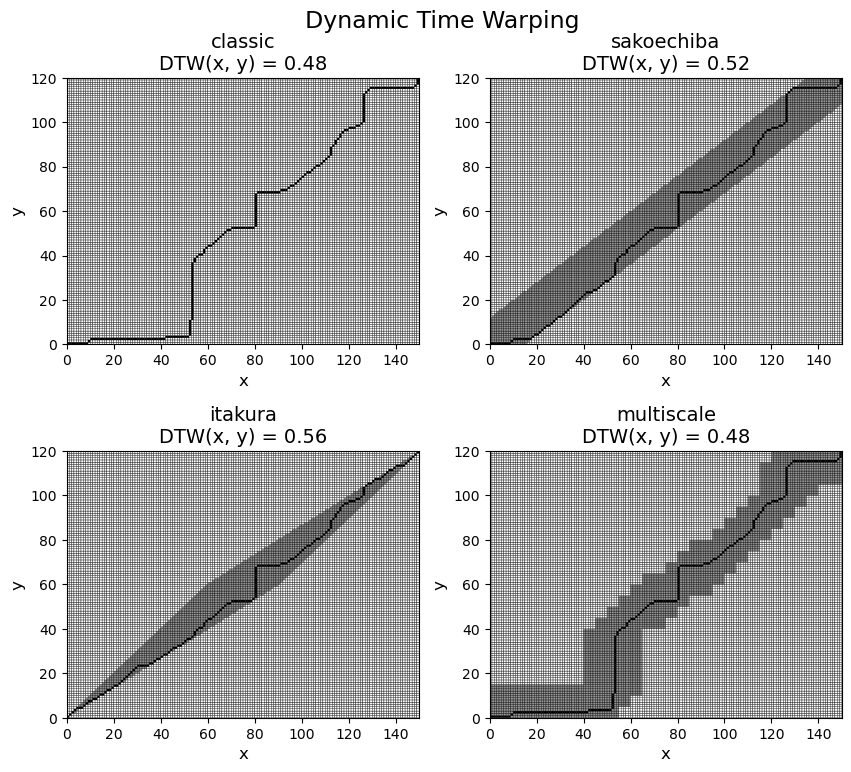

In [2]:
# Author: Johann Faouzi <johann.faouzi@gmail.com>
# License: BSD-3-Clause

import numpy as np
import matplotlib.pyplot as plt
from pyts.datasets import load_gunpoint
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)

# Parameters
X, _, _, _ = load_gunpoint(return_X_y=True)
x, y = X[0], X[1]

# To compare time series of different lengths, we remove some observations
mask = np.ones(x.size)
mask[::5] = 0
y = y[mask.astype(bool)]
n_timestamps_1, n_timestamps_2 = x.size, y.size

plt.figure(figsize=(10, 8))
timestamps_1 = np.arange(n_timestamps_1 + 1)
timestamps_2 = np.arange(n_timestamps_2 + 1)

# Dynamic Time Warping: classic
dtw_classic, path_classic = dtw(x, y, dist='square',
                                method='classic', return_path=True)
matrix_classic = np.zeros((n_timestamps_1, n_timestamps_2))
matrix_classic[tuple(path_classic)] = 1.

plt.subplot(2, 2, 1)
plt.pcolor(timestamps_1, timestamps_2, matrix_classic.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("{0}\nDTW(x, y) = {1:.2f}".format('classic', dtw_classic),
          fontsize=14)

# Dynamic Time Warping: sakoechiba
window_size = 0.1
dtw_sakoechiba, path_sakoechiba = dtw(
    x, y, dist='square', method='sakoechiba',
    options={'window_size': window_size}, return_path=True
)
band = sakoe_chiba_band(n_timestamps_1, n_timestamps_2,
                        window_size=window_size)
matrix_sakoechiba = np.zeros((n_timestamps_1, n_timestamps_2))
for i in range(n_timestamps_1):
    matrix_sakoechiba[i, np.arange(*band[:, i])] = 0.5
matrix_sakoechiba[tuple(path_sakoechiba)] = 1.

plt.subplot(2, 2, 2)
plt.pcolor(timestamps_1, timestamps_2, matrix_sakoechiba.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("{0}\nDTW(x, y) = {1:.2f}".format('sakoechiba', dtw_sakoechiba),
          fontsize=14)

# Dynamic Time Warping: itakura
slope = 1.2
dtw_itakura, path_itakura = dtw(
    x, y, dist='square', method='itakura',
    options={'max_slope': slope}, return_path=True
)
parallelogram = itakura_parallelogram(n_timestamps_1, n_timestamps_2,
                                      max_slope=slope)
matrix_itakura = np.zeros((n_timestamps_1, n_timestamps_2))
for i in range(n_timestamps_1):
    matrix_itakura[i, np.arange(*parallelogram[:, i])] = 0.5
matrix_itakura[tuple(path_itakura)] = 1.
plt.subplot(2, 2, 3)
plt.pcolor(timestamps_1, timestamps_2, matrix_itakura.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("{0}\nDTW(x, y) = {1:.2f}".format('itakura', dtw_itakura),
          fontsize=14)

# Dynamic Time Warping: multiscale
resolution, radius = 5, 2
dtw_multiscale, path_multiscale = dtw(
    x, y, dist='square', method='multiscale',
    options={'resolution': resolution, 'radius': radius}, return_path=True
)

x_padded = x.reshape(-1, resolution).mean(axis=1)
y_padded = y.reshape(-1, resolution).mean(axis=1)

cost_mat_res = cost_matrix(x_padded, y_padded, dist='square', region=None)
acc_cost_mat_res = accumulated_cost_matrix(cost_mat_res)
path_res = _return_path(acc_cost_mat_res)

multiscale_region = _blurred_path_region(
    n_timestamps_1, n_timestamps_2, resolution, x_padded.size, y_padded.size,
    path_res,
    radius=radius
)
matrix_multiscale = np.zeros((n_timestamps_1, n_timestamps_2))
for i in range(n_timestamps_1):
    matrix_multiscale[i, np.arange(*multiscale_region[:, i])] = 0.5
matrix_multiscale[tuple(path_multiscale)] = 1.

plt.subplot(2, 2, 4)
plt.pcolor(timestamps_1, timestamps_2, matrix_multiscale.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("{0}\nDTW(x, y) = {1:.2f}".format('multiscale', dtw_multiscale),
          fontsize=14)

plt.suptitle("Dynamic Time Warping", y=0.995, fontsize=17)
plt.subplots_adjust(top=0.91, hspace=0.4)
plt.show()